In [1]:
from __future__ import division
import time, datetime
import os.path
import numpy as np
import tqdm # task bar
import matplotlib.pyplot as plt
%matplotlib notebook
import idx2numpy as inp
import scipy.sparse.linalg
import scipy.spatial.distance as dist
from sklearn import svm

import sys
sys.path.append('/home/jianwei/Programs/libsvm/python/')
from svmutil import *

# Load Data

In [2]:
TsImgs = np.array([img.flatten() for img in inp.convert_from_file('t10k-images.idx3-ubyte')])
TrImgs = np.array([img.flatten() for img in inp.convert_from_file('train-images.idx3-ubyte')])
TrLbls = inp.convert_from_file('train-labels.idx1-ubyte')
TsLbls = inp.convert_from_file('t10k-labels.idx1-ubyte')

In [3]:
[TrImgs40Comps,TrImgs80Comps,TrImgs200Comps] = [np.load('TrImgs{}Comps.npy'.format(c)) for c in [40,80,200]]
[TsImgs40Comps,TsImgs80Comps,TsImgs200Comps] = [np.load('TsImgs{}Comps.npy'.format(c)) for c in [40,80,200]]

# Rescale Data

In [4]:
# Scale Data
def ScaleOne(ndarray):
    L = len(ndarray)
    """scales a 1D array"""
    vmax = np.max(ndarray)
    vmin = np.min(ndarray)
    if vmax==vmin:
#         return ndarray
        return np.zeros(L)
    else:
        return [-1.0 + (1.0 - (-1.0)) * (val - vmin)/(vmax-vmin) for val in ndarray]
def ScaleAll(Imgs):
    """
    scales the features of a 2D array of images
    each row in Imgs is an Image vector
    each column represents a feature vector listing the values from all Imgs
    """
    Imgs = np.array(Imgs)
    return np.array([ScaleOne(feature) for feature in Imgs.T]).T

In [5]:
# Convert List of Images to something LIBSVM likes...
from multiprocessing import Pool
def con(ndarray):
#     return Pool(4).imap(list,ndarray)
    return [list(row) for row in ndarray]

# Sample Run

In [8]:
time_start = time.time()
con(ScaleAll(TrImgs200Comps))
time_end = time.time()

In [9]:
(time_end-time_start)

18.739754915237427

In [125]:
# %timeit svm_problem(list(TrLbls[:5000]),con(ScaleAll(TrImgs200Comps[:2000])))
prob = svm_problem(list(TrLbls[:10000]),con(ScaleAll(TrImgs200Comps[:10000])))

In [130]:
# param = svm_parameter('-t 2 -g 0.008 -c 13')
# param = svm_parameter('-t 2 -g 0.015 -c 10')
param = svm_parameter('-t 2 -g 0.008 -c 10')

In [131]:
model = svm_train(prob, param)

In [133]:
p_labels, p_acc, p_vals = svm_predict(list(TsLbls[1000:2000]),con(ScaleAll(TsImgs200Comps[1000:2000])),model)

Accuracy = 89.5% (895/1000) (classification)


In [135]:
len(TrLbls)/10

6000.0

# Generate Penalty List

In [7]:
penalty = [1e-2,1e-1,1,1e1]

In [6]:
def append2file(filename,text):
    f=open(filename,'a+')
    f.write(text)
    f.close()

# Linear SVM
* Run for 40, 80, 200 Components
* Run for various C value
* Save output

In [12]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M")
TrL = len(TrLbls) # number of samples in Training Set to include
TsL = len(TsLbls) # number of samples in Test Set to include
Components = [40,80,200]
filename = 'LinearSvmResults_'+timestamp+'.dat'
with open(filename,'w+') as f:
    f.write('#Components\tPenalty\tAccuracy(%)\n')
for i, (TrImgsPComps, TsImsPComps) in \
enumerate(zip([TrImgs40Comps,TrImgs80Comps,TrImgs200Comps],[TsImgs40Comps,TsImgs80Comps,TsImgs200Comps])):
    print 'Computing for {} components...'.format(Components[i])
    prob = svm_problem(list(TrLbls[:TrL]),con(ScaleAll(TrImgsPComps[:TrL])))
    for c in penalty:
        print 'penalty {}'.format(c)
        param = svm_parameter('-t 0 -d 1 -c {}'.format(c))
        model = model=svm_train(prob, param)
        p_labels, p_acc, p_vals = svm_predict(list(TsLbls[:TsL]),con(ScaleAll(TsImsPComps[:TsL])),model)
        append2file(filename,
                   '{}\t{}\t{}\n'.format(Components[i],c,p_acc[0]))

Computing for 40 components...
penalty 0.01
Accuracy = 88.95% (8895/10000) (classification)
penalty 0.1
Accuracy = 90.23% (9023/10000) (classification)
penalty 1
Accuracy = 90.23% (9023/10000) (classification)
penalty 10.0
Accuracy = 90.2% (9020/10000) (classification)
Computing for 80 components...
penalty 0.01
Accuracy = 90.82% (9081/10000) (classification)
penalty 0.1
Accuracy = 91.98% (9198/10000) (classification)
penalty 1
Accuracy = 91.86% (9186/10000) (classification)
penalty 10.0
Accuracy = 91.09% (9109/10000) (classification)
Computing for 200 components...
penalty 0.01
Accuracy = 92.18% (9218/10000) (classification)
penalty 0.1
Accuracy = 92.81% (9281/10000) (classification)
penalty 1
Accuracy = 92.1% (9210/10000) (classification)
penalty 10.0
Accuracy = 91.44% (9144/10000) (classification)


In [9]:
penalty[-1:]

[10.0]

# Visualise Results
* which I got at seperate runs...

In [14]:
# penalty = [1e-2,1e-1,1,1e1]
r40 = [88.95,90.23,90.23,90.2]
r80 = [90.82,91.98,91.86,91.09]
r200 = [92.18,92.81,92.1,91.44]

<IPython.core.display.Javascript object>


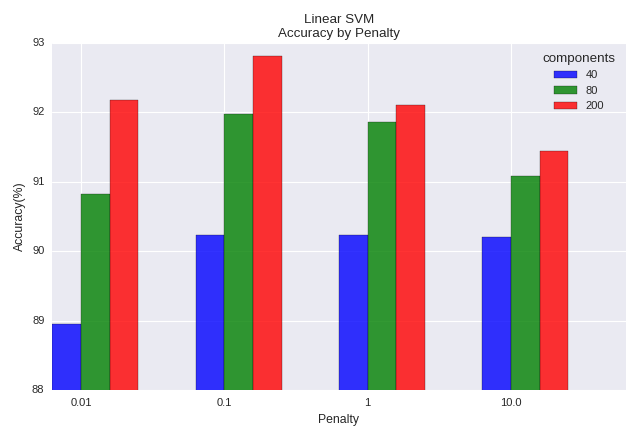

In [18]:
import seaborn
 
# data to plot
n_groups = 4
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8
 
rects1 = plt.bar(index, r40, bar_width,
                 alpha=opacity,
                 color='b',
                 label='40')
 
rects2 = plt.bar(index + bar_width, r80, bar_width,
                 alpha=opacity,
                 color='g',
                 label='80')

rects3 = plt.bar(index + 2*bar_width, r200, bar_width,
                 alpha=opacity,
                 color='r',
                 label='200')
plt.ylim(88,93) 
plt.xlabel('Penalty')
plt.ylabel('Accuracy(%)')
plt.title('Linear SVM\nAccuracy by Penalty')
plt.xticks(index + bar_width, penalty)
plt.legend(loc='best',title='components')
 
plt.tight_layout()
plt.show()

# Observations:
* Accuracy tends to increases with number of components. This is expected since the data is better represented with a higher number of componenets.
* There is an optimum penalty value. 
    * A lower margin of error at higher penalties means that there is a higher tendency for overfitting on the training set and hence poorer performance on the test set. This is further evidenced by the fact that the accuracy decreased most drastically with increasing penalty, for the training set with the fewest components (40). 
    * A higher margin of error at too low a penalty means that classification errors increase for both data and test set.

# Radial SVM

## Optimisation on partial Datasets

In [59]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M")
TrL = int(len(TrLbls)/10) # number of samples in Training Set to include
TsL = int(len(TsLbls)/10) # number of samples in Test Set to include
Components = [40,80,200]
gammas = [0.01,0.05,0.1,0.15,0.3]
# penalty = [1,10,20,30]
# penalty = [1,10,100,1000]
penalty = [0.01,0.1,1,10]
filename = 'RadialSvmOptimisationResults_'+timestamp+'.dat'
with open(filename,'w+') as f:
    f.write('#Components\tPenalty\tGamma\tAccuracy(%)\n')
for i, (TrImgsPComps, TsImsPComps) in \
enumerate(zip([TrImgs40Comps,TrImgs80Comps,TrImgs200Comps],[TsImgs40Comps,TsImgs80Comps,TsImgs200Comps])):
    print 'Computing for {} components...'.format(Components[i])
    prob = svm_problem(list(TrLbls[:TrL]),con(ScaleAll(TrImgsPComps[:TrL])))
    for c in penalty:
        print 'penalty {}'.format(c)
        # Radial Basis: -t option set to 2
        for g in gammas: 
            print 'gamma {}'.format(g)
            param = svm_parameter('-t 2 -g {} -c {}'.format(g, c))
            model = svm_train(prob, param)
            p_labels, p_acc, p_vals = svm_predict(list(TsLbls[:TsL]),con(ScaleAll(TsImsPComps[:TsL])),model)
            append2file(filename,
                       '{}\t{}\t{}\t{}\n'.format(Components[i],c,g,p_acc[0]))

Computing for 40 components...
penalty 0.01
gamma 0.01


/home/jianwei/Programs/libsvm/python/svmutil.py:81: RuntimeWarning: invalid value encountered in double_scalars
  SCC = ((l*sumvy-sumv*sumy)*(l*sumvy-sumv*sumy))/((l*sumvv-sumv*sumv)*(l*sumyy-sumy*sumy))


Accuracy = 12.6% (126/1000) (classification)
gamma 0.05
Accuracy = 37.2% (372/1000) (classification)
gamma 0.1
Accuracy = 55.4% (554/1000) (classification)
gamma 0.15
Accuracy = 62.7% (627/1000) (classification)
gamma 0.3
Accuracy = 60.3% (603/1000) (classification)
penalty 0.1
gamma 0.01
Accuracy = 71.3% (713/1000) (classification)
gamma 0.05
Accuracy = 82.1% (821/1000) (classification)
gamma 0.1
Accuracy = 85.2% (852/1000) (classification)
gamma 0.15
Accuracy = 86.3% (863/1000) (classification)
gamma 0.3
Accuracy = 87.5% (875/1000) (classification)
penalty 1
gamma 0.01
Accuracy = 83.3% (833/1000) (classification)
gamma 0.05
Accuracy = 88% (880/1000) (classification)
gamma 0.1
Accuracy = 90.6% (906/1000) (classification)
gamma 0.15
Accuracy = 92% (920/1000) (classification)
gamma 0.3
Accuracy = 93.5% (935/1000) (classification)
penalty 10
gamma 0.01
Accuracy = 86.8% (868/1000) (classification)
gamma 0.05
Accuracy = 91.2% (912/1000) (classification)
gamma 0.1
Accuracy = 91.4% (914/1000

In [28]:
from mpl_toolkits.mplot3d import Axes3D

('Components', 'Penalty', 'Gamma', 'Accuracy')


<IPython.core.display.Javascript object>


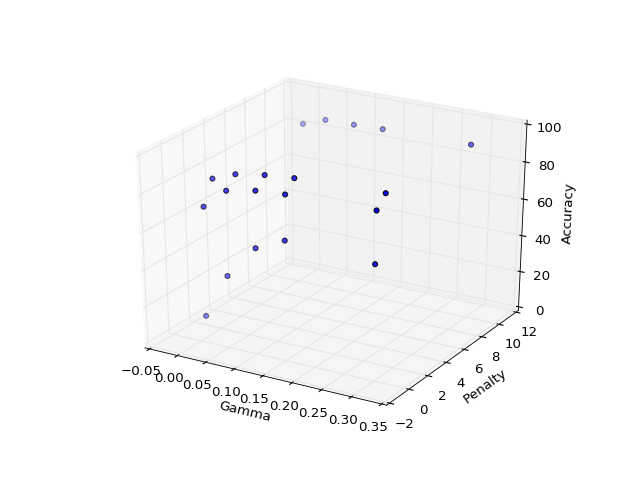

<IPython.core.display.Javascript object>


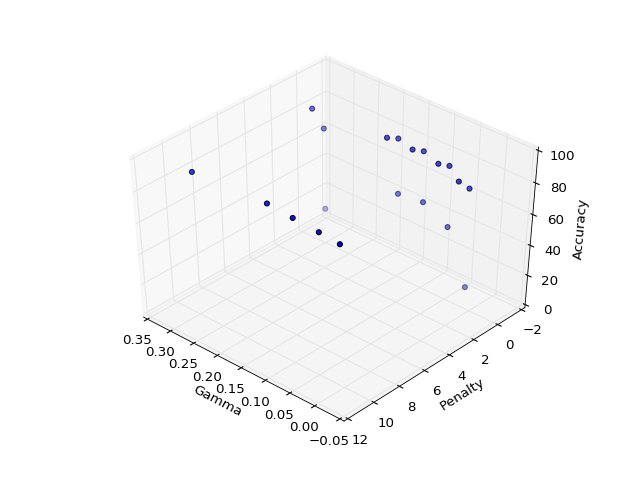

<IPython.core.display.Javascript object>


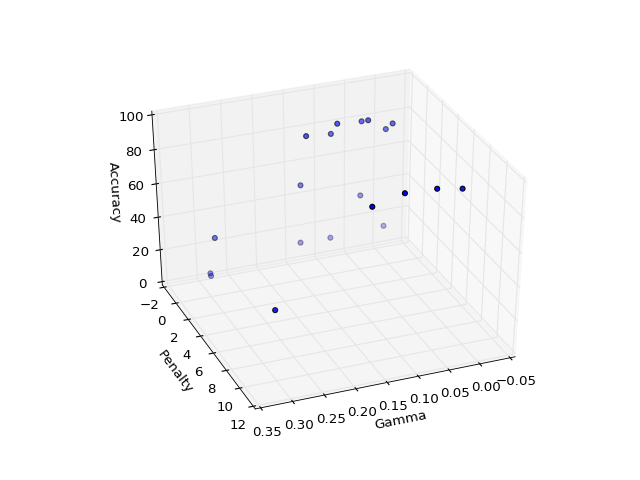

In [60]:
data = np.genfromtxt(filename,names=True)
print data.dtype.names
for c in np.unique(data['Components']):
    mask = data['Components']==c
    fig = plt.figure()
    fig.set_label(c)
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(data['Gamma'][mask],data['Penalty'][mask],data['Accuracy'][mask])
    ax.set_xlabel('Gamma')
    ax.set_ylabel('Penalty')
    ax.set_zlabel('Accuracy')

## Optimise for 40 component data

In [55]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M")
TrL = int(len(TrLbls)/10) # number of samples in Training Set to include
TsL = int(len(TsLbls)/10) # number of samples in Test Set to include
Components = [40]
gammas = [0.15,0.3,0.5,1]
# penalty = [1,10,20,30]
penalty = [0.01,0.1,1,10]
filename = 'RadialSvmOptimisationResults_'+timestamp+'.dat'
with open(filename,'w+') as f:
    f.write('#Components\tPenalty\tGamma\tAccuracy(%)\n')
for i, (TrImgsPComps, TsImsPComps) in \
enumerate(zip([TrImgs40Comps,TrImgs80Comps,TrImgs200Comps],[TsImgs40Comps,TsImgs80Comps,TsImgs200Comps])):
    print 'Computing for {} components...'.format(Components[i])
    prob = svm_problem(list(TrLbls[:TrL]),con(ScaleAll(TrImgsPComps[:TrL])))
    for c in penalty:
        print 'penalty {}'.format(c)
        # Radial Basis: -t option set to 2
        for g in gammas: 
            print 'gamma {}'.format(g)
            param = svm_parameter('-t 2 -g {} -c {}'.format(g, c))
            model = svm_train(prob, param)
            p_labels, p_acc, p_vals = svm_predict(list(TsLbls[:TsL]),con(ScaleAll(TsImsPComps[:TsL])),model)
            append2file(filename,
                       '{}\t{}\t{}\t{}\n'.format(Components[i],c,g,p_acc[0]))

Computing for 40 components...
penalty 0.01
gamma 0.15
Accuracy = 62.7% (627/1000) (classification)
gamma 0.3
Accuracy = 60.3% (603/1000) (classification)
gamma 0.5
Accuracy = 46.7% (467/1000) (classification)
gamma 1
Accuracy = 20% (200/1000) (classification)
penalty 0.1
gamma 0.15
Accuracy = 86.3% (863/1000) (classification)
gamma 0.3
Accuracy = 87.5% (875/1000) (classification)
gamma 0.5
Accuracy = 85.1% (851/1000) (classification)
gamma 1
Accuracy = 47.7% (477/1000) (classification)
penalty 1
gamma 0.15
Accuracy = 92% (920/1000) (classification)
gamma 0.3
Accuracy = 93.5% (935/1000) (classification)
gamma 0.5
Accuracy = 92.7% (927/1000) (classification)
gamma 1
Accuracy = 81.9% (819/1000) (classification)
penalty 10
gamma 0.15
Accuracy = 91.9% (919/1000) (classification)
gamma 0.3
Accuracy = 92.3% (923/1000) (classification)
gamma 0.5
Accuracy = 92.5% (925/1000) (classification)
gamma 1
Accuracy = 82.5% (825/1000) (classification)


IndexError: list index out of range

('Components', 'Penalty', 'Gamma', 'Accuracy')


<IPython.core.display.Javascript object>


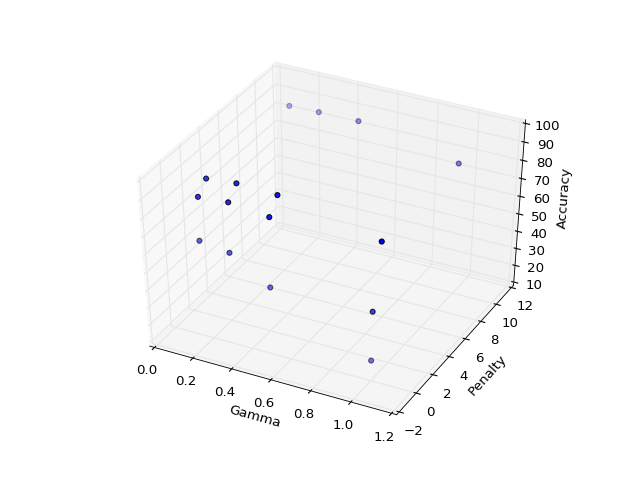

In [56]:
data = np.genfromtxt(filename,names=True)
print data.dtype.names
for c in np.unique(data['Components']):
    mask = data['Components']==c
    fig = plt.figure()
    fig.set_label(c)
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(data['Gamma'][mask],data['Penalty'][mask],data['Accuracy'][mask])
    ax.set_xlabel('Gamma')
    ax.set_ylabel('Penalty')
    ax.set_zlabel('Accuracy')

In [ ]:
#40, c = 1, g = 0.3,
#80, c = 0.15, g = 1
#200, c = 0.1, g = 1

In [68]:
TrImgs200Comps[0].shape

(200,)

# Apply Radial SVM to full Data Set

In [64]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M")
TrL = int(len(TrLbls)) # number of samples in Training Set to include
TsL = int(len(TsLbls)) # number of samples in Test Set to include
Components = [40,80,200]
gammas = [0.3,1,0.1]
penalty = [1,0.15,10]
filename = 'RadialSvmOptimisedResults_'+timestamp+'.dat'
with open(filename,'w+') as f:
    f.write('#Components\tPenalty\tGamma\tAccuracy(%)\n')
for i, (TrImgsPComps, TsImsPComps) in \
enumerate(zip([TrImgs40Comps,TrImgs80Comps,TrImgs200Comps],[TsImgs40Comps,TsImgs80Comps,TsImgs200Comps])):
    if Components[i]==200:
        print 'Computing for {} components...'.format(Components[i])
        prob = svm_problem(list(TrLbls[:TrL]),con(ScaleAll(TrImgsPComps[:TrL])))
        print 'penalty {}'.format(penalty[i])
        # Radial Basis: -t option set to 2
        print 'gamma {}'.format(gammas[i])
        param = svm_parameter('-t 2 -g {} -c {}'.format(g, c))
        model = svm_train(prob, param)
        p_labels, p_acc, p_vals = svm_predict(list(TsLbls[:TsL]),con(ScaleAll(TsImsPComps[:TsL])),model)
        append2file(filename,
                   '{}\t{}\t{}\t{}\n'.format(Components[i],penalty[i],gammas[i],p_acc[0]))

Computing for 200 components...
penalty 10
gamma 0.1
Accuracy = 94.24% (9424/10000) (classification)


Computing for 40 components...
penalty 1
gamma 0.3
Accuracy = 96.63% (9663/10000) (classification)
Computing for 80 components...
penalty 0.15
gamma 1
Accuracy = 98.1% (9810/10000) (classification)
Computing for 200 components...
penalty 0.1
gamma 1
Accuracy = 94.24% (9424/10000) (classification)

# Plot Radial Results against Linear Results

# Some Sanity Checks in the scaling of vectors

In [16]:
def verify(arr):
    Nc = np.shape(arr)[1]
    print Nc
    for c in np.arange(Nc):
        cmax=np.max(arr[:,c])
        cmin=np.min(arr[:,c])
        if ((cmax!=1)or(cmin!=-1)):
            print c, cmax, cmin

In [17]:
a=np.array(con(ScaleAll(TrImgs40Comps)))
verify(a)

784
0 0.0 0.0
1 0.0 0.0
2 0.0 0.0
3 0.0 0.0
4 0.0 0.0
5 0.0 0.0
6 0.0 0.0
7 0.0 0.0
8 0.0 0.0
9 0.0 0.0
10 0.0 0.0
11 0.0 0.0
12 0.0 0.0
13 0.0 0.0
14 0.0 0.0
15 0.0 0.0
16 0.0 0.0
17 0.0 0.0
18 0.0 0.0
19 0.0 0.0
20 0.0 0.0
21 0.0 0.0
22 0.0 0.0
23 0.0 0.0
24 0.0 0.0
25 0.0 0.0
26 0.0 0.0
27 0.0 0.0
28 0.0 0.0
29 0.0 0.0
30 0.0 0.0
31 0.0 0.0
32 0.0 0.0
33 0.0 0.0
34 0.0 0.0
35 0.0 0.0
49 0.0 0.0
50 0.0 0.0
51 0.0 0.0
52 0.0 0.0
53 0.0 0.0
54 0.0 0.0
55 0.0 0.0
56 0.0 0.0
57 0.0 0.0
58 0.0 0.0
59 0.0 0.0
60 0.0 0.0
61 0.0 0.0
80 0.0 0.0
81 0.0 0.0
82 0.0 0.0
83 0.0 0.0
84 0.0 0.0
85 0.0 0.0
86 0.0 0.0
87 0.0 0.0
88 0.0 0.0
109 0.0 0.0
110 0.0 0.0
111 0.0 0.0
112 0.0 0.0
113 0.0 0.0
114 0.0 0.0
115 0.0 0.0
138 0.0 0.0
139 0.0 0.0
140 0.0 0.0
141 0.0 0.0
142 0.0 0.0
144 0.0 0.0
167 0.0 0.0
168 0.0 0.0
169 0.0 0.0
170 0.0 0.0
195 0.0 0.0
196 0.0 0.0
197 0.0 0.0
223 0.0 0.0
224 0.0 0.0
226 0.0 0.0
251 0.0 0.0
279 0.0 0.0
280 0.0 0.0
308 0.0 0.0
310 0.0 0.0
333 0.0 0.0
335 0.0 0.0
338 0.0 